# &#x1F4D1; &nbsp; TensorFlow  Cookbook 
## 0. Code Library and Links
- [Generative Adversarial Nets in TensorFlow](https://wiseodd.github.io/techblog/2016/09/17/gan-tensorflow/)

In [1]:
%%html
<style>
@import url('https://fonts.googleapis.com/css?family=Orbitron|Roboto');
body {background-color: gainsboro;} 
a {color: green; font-family: 'Roboto';} 
h1 {color: slategray; font-family: 'Orbitron'; text-shadow: 4px 4px 4px #aaa;} 
h2, h3 {color: darkslategray; font-family: 'Orbitron'; text-shadow: 4px 4px 4px #aaa;}
h4 {color: slategray; font-family: 'Roboto';}
div.output_prompt, div.output_area pre {color: darkslategray;}
div.input_prompt, div.output_subarea {color: green;}      
div.output_stderr pre {background-color: ghostwhite;}  
div.output_stderr {background-color: gainsboro;}        
</style>

In [2]:
import numpy as np 
import pandas as pd
import math
from scipy import misc
from collections import namedtuple

import cv2
from PIL import ImageFile, Image
from tqdm import tqdm
from glob import glob

from keras.preprocessing import image as keras_image
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split

from matplotlib import rcParams
import matplotlib.pyplot as plt
import matplotlib.image as plt_image
from matplotlib import cm

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

Using TensorFlow backend.


In [3]:
import tensorflow as tf
import tflearn

In [4]:
import tflearn.datasets.mnist as mnist
from tflearn.data_utils import build_hdf5_image_dataset

## 1. Data Sets

In [5]:
# MNIST
X_train, y_train, X_test, y_test = mnist.load_data(one_hot=True)

Extracting mnist/train-images-idx3-ubyte.gz
Extracting mnist/train-labels-idx1-ubyte.gz
Extracting mnist/t10k-images-idx3-ubyte.gz
Extracting mnist/t10k-labels-idx1-ubyte.gz


In [6]:
digit_images = X_train.reshape(-1, 28, 28, 1)
[X_train.shape, y_train.shape, X_test.shape, y_test.shape]

[(55000, 784), (55000, 10), (10000, 784), (10000, 10)]

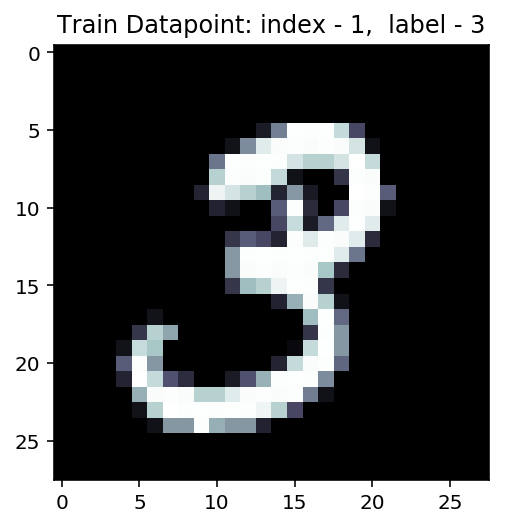

In [129]:
def display_digit(index):
    label = y_train[index].argmax(axis=0)
    image = (X_train[index].reshape(28,28)/255-0.5)*2
    plt.title('Train Datapoint: index - %d,  label - %d' % (index, label))
    plt.imshow(image, cmap=cm.bone)

display_digit(1)

In [8]:
# Anna Karenina Text
with open('anna.txt', 'r') as f:
    text=f.read()
vocabulary = set(text)
int_to_vocab = dict(enumerate(vocabulary))
vocab_to_int = dict((v,k) for k,v in int_to_vocab.items())
characters = np.array([vocab_to_int[c] for c in text], dtype=np.int32)

In [9]:
text[:109]

'Chapter 1\n\n\nHappy families are all alike; every unhappy family is unhappy in its own\nway.\n\nEverything was in '

In [10]:
characters[:109]

array([62, 12, 33, 82, 60, 14, 44, 47, 29, 58, 58, 58,  7, 33, 82, 82,  8,
       47, 36, 33, 64, 24,  9, 24, 14, 48, 47, 33, 44, 14, 47, 33,  9,  9,
       47, 33,  9, 24, 35, 14, 54, 47, 14, 70, 14, 44,  8, 47, 25, 46, 12,
       33, 82, 82,  8, 47, 36, 33, 64, 24,  9,  8, 47, 24, 48, 47, 25, 46,
       12, 33, 82, 82,  8, 47, 24, 46, 47, 24, 60, 48, 47, 74, 57, 46, 58,
       57, 33,  8, 72, 58, 58, 71, 70, 14, 44,  8, 60, 12, 24, 46, 10, 47,
       57, 33, 48, 47, 24, 46, 47], dtype=int32)

In [11]:
batch_size, num_steps, split_fraction = 100, 100, 0.9

slice_size = batch_size * num_steps
n_batches = int(len(characters) / slice_size)
# targets = features, shifted one character over
X2 = characters[: n_batches*slice_size]
y2 = characters[1: n_batches*slice_size + 1]

X2 = np.stack(np.split(X2, batch_size))
y2 = np.stack(np.split(y2, batch_size))

split_id = int(n_batches*split_fraction)
X_train2, y_train2= X2[:, :split_id*num_steps], y2[:, :split_id*num_steps]
X_test2, y_test2 = X2[:, split_id*num_steps:], y2[:, split_id*num_steps:]    

In [12]:
[X_train2.shape, y_train2.shape, X_test2.shape, y_test2.shape]

[(100, 17800), (100, 17800), (100, 2000), (100, 2000)]

In [7]:
# 128x128 color images
flowers = pd.read_csv("flower_images/flower_labels.csv")
flower_files = flowers['file']
flower_targets = flowers['label'].as_matrix()

def path_to_tensor(img_path):
    img = keras_image.load_img("flower_images/"+img_path, target_size=(128, 128))
    x = keras_image.img_to_array(img)
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

ImageFile.LOAD_TRUNCATED_IMAGES = True                 
flower_tensors = paths_to_tensor(flower_files);

100%|██████████| 210/210 [00:26<00:00,  7.43it/s]


Label:  7


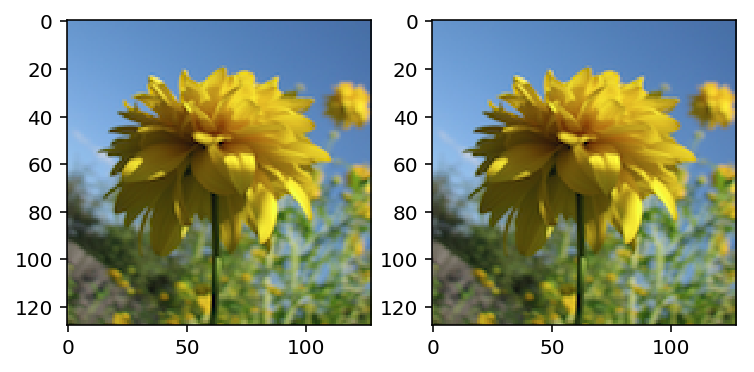

In [8]:
# rgb_image = tf.image.decode_png("flower_images/0023.png")
# rgb_image_float = tf.image.convert_image_dtype(rgb_image, tf.float32)

img_scipy = misc.imread('flower_images/0023.png') 

image_tf = tf.Variable(img_scipy)
init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)
img_tf = sess.run(image_tf)

print('Label: ', flower_targets[22])
fig = plt.figure()
fig.add_subplot(1,2,1)
plt.imshow(img_scipy)
fig.add_subplot(1,2,2)
plt.imshow(img_tf);

In [9]:
X_train3, X_test3, y_train3, y_test3 = train_test_split(flower_tensors, flower_targets, 
                                                        test_size = 0.1, random_state = 1)
X_train3 = X_train3.astype('float32')/255
X_test3 = X_test3.astype('float32')/255

c_y_train3 = to_categorical(y_train3, 10)
c_y_test3 = to_categorical(y_test3, 10)
[X_train3.shape, c_y_train3.shape, X_test3.shape, c_y_test3.shape]

[(189, 128, 128, 3), (189, 10), (21, 128, 128, 3), (21, 10)]

## 2. Basics

In a **dataflow graph**, the nodes represent units of computation, and the edges represent the data consumed or produced by a computation.

A `tf.Graph` contains two relevant kinds of information:

 * Graph structure, i.e. the nodes and edges of the graph, indicating how individual operations are composed together, but not prescribing how they should be used.
 * Graph collections for storing the metadata.

In [52]:
# Create a tensorflow constant string
constant = tf.constant('This is a TensorFlow cookbook!')

with tf.Session() as session:
    print("Tensorflow version: " + tf.__version__)
    print(constant.eval())

Tensorflow version: 1.1.0
b'This is a TensorFlow cookbook!'


In [77]:
# Create a tensorflow matrices & vectors
matrix_A = tf.constant([ [2.,3.], [1.,4.] ]) # square matrix, [2,2]
matrix_B = tf.diag([5.,6.]) # square diagonal symmetric matrix, [2,2] 
matrix_C = tf.constant([ [7.,8.], [9.,1.] ]) # square matrix, [2,2]

vector_a = tf.ones([2,1])# vector with 1, [2,1]
vector_b = tf.fill([2,1], 2.) # vector with 2.0, [2,1]
vector_c = tf.constant([ [-1.], [1.] ]) # vector, [2,1]

with tf.Session() as session:
    tf.global_variables_initializer().run()

    print("Matrix A = \n", matrix_A.eval())
#    print("Matrix B = \n", matrix_B.eval())
#    print("Matrix C = \n", matrix_C.eval())    
    print("Vector a = \n", vector_a.eval())
#    print("Vector b = \n", vector_b.eval())
#    print("Vector c = \n", vector_c.eval())

    print("Tensor multiplication: ", "Matrix A x Matrix B \n ", tf.matmul(matrix_A, matrix_B).eval())
    print("Tensor addition: ", "Matrix A + Matrix B \n", tf.add(matrix_A, matrix_B).eval())

Matrix A = 
 [[ 2.  3.]
 [ 1.  4.]]
Vector a = 
 [[ 1.]
 [ 1.]]
Tensor multiplication:  Matrix A x Matrix B 
  [[ 10.  18.]
 [  5.  24.]]
Tensor addition:  Matrix A + Matrix B 
 [[  7.   3.]
 [  1.  10.]]


In [53]:
# Feed data into graphs through placeholders
x = tf.placeholder("float32", [None, None])
y = (x-0.011) ** 2

with tf.Session() as session:
    result = session.run(y, feed_dict={x: [[0.19, 0.24, 0.37], 
                                           [0.11, 0.53, 0.27], 
                                           [0.73, 0.38, 0.95],
                                           [0.43, 0.55, 0.61] ]})
    print(result)

[[ 0.032041    0.052441    0.12888099]
 [ 0.009801    0.26936099  0.067081  ]
 [ 0.51696104  0.13616098  0.88172102]
 [ 0.175561    0.29052103  0.35880104]]


In [23]:
# Reshape
t = [[0.032041, 0.047961, 0.12888099], 
     [0.175561, 0.29052103, 0.35880104],
     [0.51696104, 0.13616098, 0.88172102],
     [0.009801, 0.26936099, 0.067081]]

sess = tf.InteractiveSession()

reshaped_t = tf.reshape(t, [2, 3, -1])
reshaped_t = tf.Print(reshaped_t, [reshaped_t], message="Reshaped tensor: ")

reshaped_t.eval()

array([[[ 0.032041  ,  0.047961  ],
        [ 0.12888099,  0.175561  ],
        [ 0.29052103,  0.35880104]],

       [[ 0.51696104,  0.13616098],
        [ 0.88172102,  0.009801  ],
        [ 0.26936099,  0.067081  ]]], dtype=float32)

An **embedding** is a mapping from discrete objects, such as words, to vectors of real numbers.

The Embedding Projector provides three ways to reduce the dimensionality of a data set (`t-SNE`, `PCA`, `Custom`).

## 3. Linear Regression; TensorFlow & TfLearn

Epoch: 1000 cost= 0.232997626 W= 0.494747 b= 1.11236
Epoch: 2000 cost= 0.232996881 W= 0.494745 b= 1.11248
Epoch: 3000 cost= 0.232996270 W= 0.494743 b= 1.1126
Epoch: 4000 cost= 0.232996300 W= 0.494741 b= 1.11271
Epoch: 5000 cost= 0.232994810 W= 0.49474 b= 1.11283
Epoch: 6000 cost= 0.232994452 W= 0.494738 b= 1.11295
Epoch: 7000 cost= 0.232993290 W= 0.494736 b= 1.11307
Epoch: 8000 cost= 0.232992798 W= 0.494734 b= 1.11319
Epoch: 9000 cost= 0.232991919 W= 0.494732 b= 1.11331
Epoch: 10000 cost= 0.232992008 W= 0.49473 b= 1.11343
Epoch: 11000 cost= 0.232991114 W= 0.494728 b= 1.11355
Epoch: 12000 cost= 0.232990935 W= 0.494726 b= 1.11367
Epoch: 13000 cost= 0.232989505 W= 0.494725 b= 1.11379
Epoch: 14000 cost= 0.232989401 W= 0.494723 b= 1.11391
Epoch: 15000 cost= 0.232988402 W= 0.494721 b= 1.11403
Optimization Finished!
Training cost= 0.232988 W= 0.494721 b= 1.11403 

Testing... (Mean square loss Comparison)
Testing cost= 0.112511
Absolute mean square loss difference: 0.120477


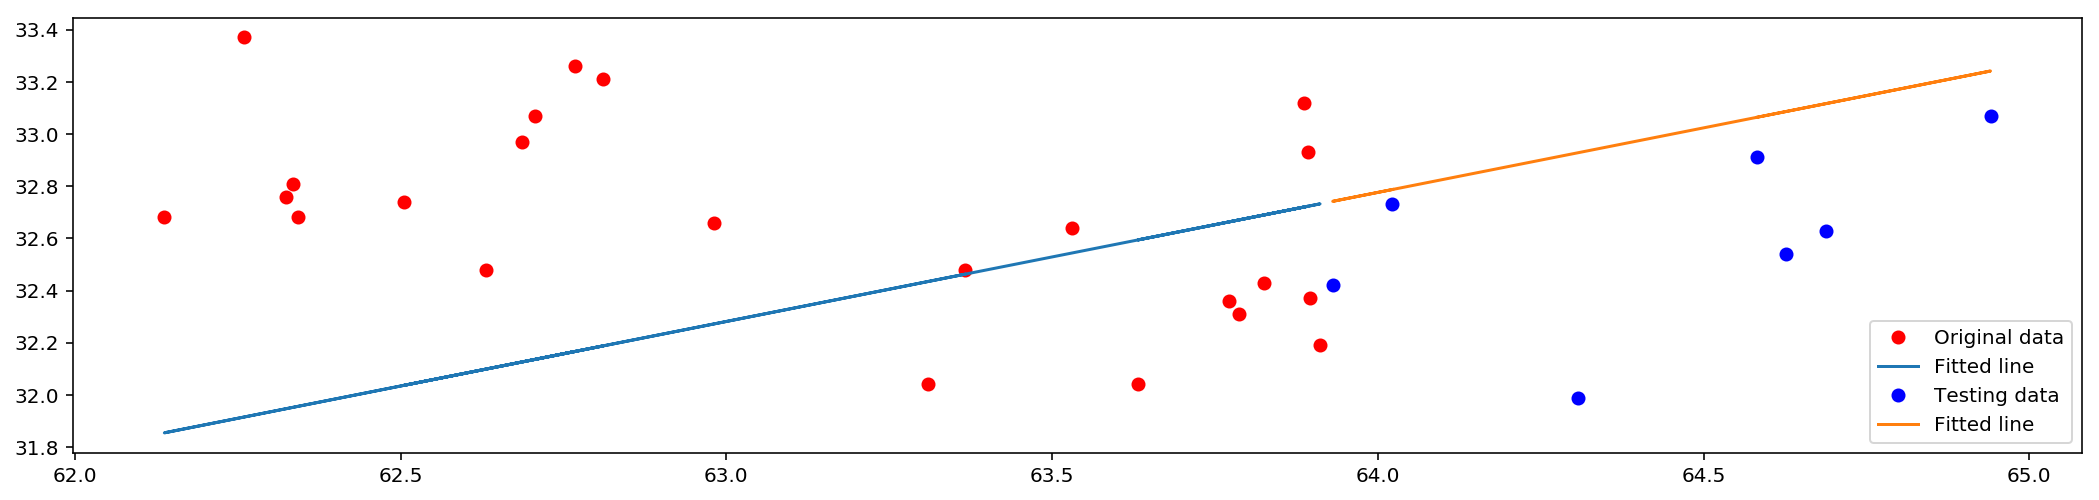

In [183]:
# Linear Regression; TensorFlow
tf.reset_default_graph()

learning_rate = 0.0035
training_epochs = 15000
display_step = 1000

# Training Data
# dual currency basket 22-08-2017--21-09-2017
train_X = np.asarray([63.7716, 63.7873, 63.8250, 63.9114, 63.8960, 63.6317, 63.8868, 63.8921, 
                      63.5300, 62.9803, 62.7065, 62.7679, 62.3237, 62.1372, 62.2597, 62.3352, 
                      62.3422, 62.8113, 62.6866, 62.5045, 62.6314, 63.3099, 63.3658])
# silver prices 22-08-2017--21-09-2017
train_Y = np.asarray([32.3600, 32.3100, 32.4300, 32.1900, 32.3700, 32.0400, 33.1200, 32.9300,
                      32.6400, 32.6600, 33.0700, 33.2600, 32.7600, 32.6800, 33.3700, 32.8100,
                      32.6800, 33.2100, 32.9700, 32.7400, 32.4800, 32.0400, 32.4800])

n_samples = train_X.shape[0]

# tf Graph Input
X = tf.placeholder("float")
Y = tf.placeholder("float")

# Set model weights
W = tf.Variable(np.random.randn(), name="weight")
b = tf.Variable(np.random.randn(), name="bias")

# Construct a linear model
pred = tf.add(tf.multiply(X, W), b)

# Mean squared error
cost = tf.reduce_sum(tf.pow(pred-Y, 2))/(2*n_samples)
# Gradient descent
#  Note, minimize() knows to modify W and b because Variable objects are trainable=True by default
optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(cost)

# Initialize the variables (i.e. assign their default value)
init = tf.global_variables_initializer()

# Start training
with tf.Session() as sess:

    # Run the initializer
    sess.run(init)

    # Fit all training data
    for epoch in range(training_epochs):
        for (x, y) in zip(train_X, train_Y):
            sess.run(optimizer, feed_dict={X: x, Y: y})

        # Display logs per epoch step
        if (epoch+1) % display_step == 0:
            c = sess.run(cost, feed_dict={X: train_X, Y:train_Y})
            print("Epoch:", '%04d' % (epoch+1), "cost=", "{:.9f}".format(c), \
                "W=", sess.run(W), "b=", sess.run(b))

    print("Optimization Finished!")
    training_cost = sess.run(cost, feed_dict={X: train_X, Y: train_Y})
    print("Training cost=", training_cost, "W=", sess.run(W), "b=", sess.run(b), '\n')

    # Graphic display
    plt.figure(figsize=(18,4))
    plt.plot(train_X, train_Y, 'ro', label='Original data')
    plt.plot(train_X, sess.run(W) * train_X + sess.run(b), label='Fitted line')
    plt.legend()
    
    # Testing example, as requested (Issue #2)
    # dual currency basket 11-08-2017--19-08-2017
    test_X = np.asarray([64.5819, 64.9406, 64.6885, 64.6269, 64.3068, 63.9308, 64.0225])
    # silver prices 11-08-2017--19-08-2017
    test_Y = np.asarray([32.9100, 33.0700, 32.6300, 32.5400, 31.9900, 32.4200, 32.7300])

    print("Testing... (Mean square loss Comparison)")
    testing_cost = sess.run(
        tf.reduce_sum(tf.pow(pred - Y, 2)) / (2 * test_X.shape[0]),
        feed_dict={X: test_X, Y: test_Y})  # same function as cost above
    print("Testing cost=", testing_cost)
    print("Absolute mean square loss difference:", abs(
        training_cost - testing_cost))

    plt.plot(test_X, test_Y, 'bo', label='Testing data')
    plt.plot(test_X, sess.run(W) * test_X + sess.run(b), label='Fitted line')
    plt.legend()

In [184]:
# Linear Regression; TFLearn
dual_currency_basket_210917 = [63.7716, 63.7873, 63.8250, 63.9114, 63.8960, 63.6317, 63.8868, 63.8921, 
                               63.5300, 62.9803, 62.7065, 62.7679, 62.3237, 62.1372, 62.2597, 62.3352, 
                               62.3422, 62.8113, 62.6866, 62.5045, 62.6314, 63.3099, 63.3658]


gold_210917 = [2448.2700, 2439.3300, 2445.6800, 2444.9900, 2447.5000, 2419.3500, 2490.4400, 2474.7200, 
               2457.8800, 2460.8400, 2479.3200, 2475.8400, 2470.5400, 2462.5800, 2475.5000, 2460.6700, 
               2441.8000, 2470.0800, 2457.3000, 2450.9100, 2435.1400, 2444.1000, 2457.4000]

In [185]:
tf.reset_default_graph()
lr_inputs = tflearn.input_data(shape=[None])
lr = tflearn.single_unit(lr_inputs)
                    
linear_regression = tflearn.regression(lr, optimizer='sgd', loss='mean_square',
                                       metric='R2', learning_rate=0.005)
dnn_lr = tflearn.DNN(linear_regression)
dnn_lr.fit(dual_currency_basket_210917, gold_210917, 
           n_epoch=2000, show_metric=True, snapshot_epoch=False)

Training Step: 2000  | total loss: 1045.70850 | time: 0.005s
| SGD | epoch: 2000 | loss: 1045.70850 - R2: 1.0002 -- iter: 23/23


In [186]:
print("Regression result: \n")
print("gold_210917 = " + str(dnn_lr.get_weights(lr.W)) +
      " * dual_currency_basket_210917 + " + str(dnn_lr.get_weights(lr.b)))

Regression result: 

gold_210917 = [ 38.8997612] * dual_currency_basket_210917 + [ 1.77371824]


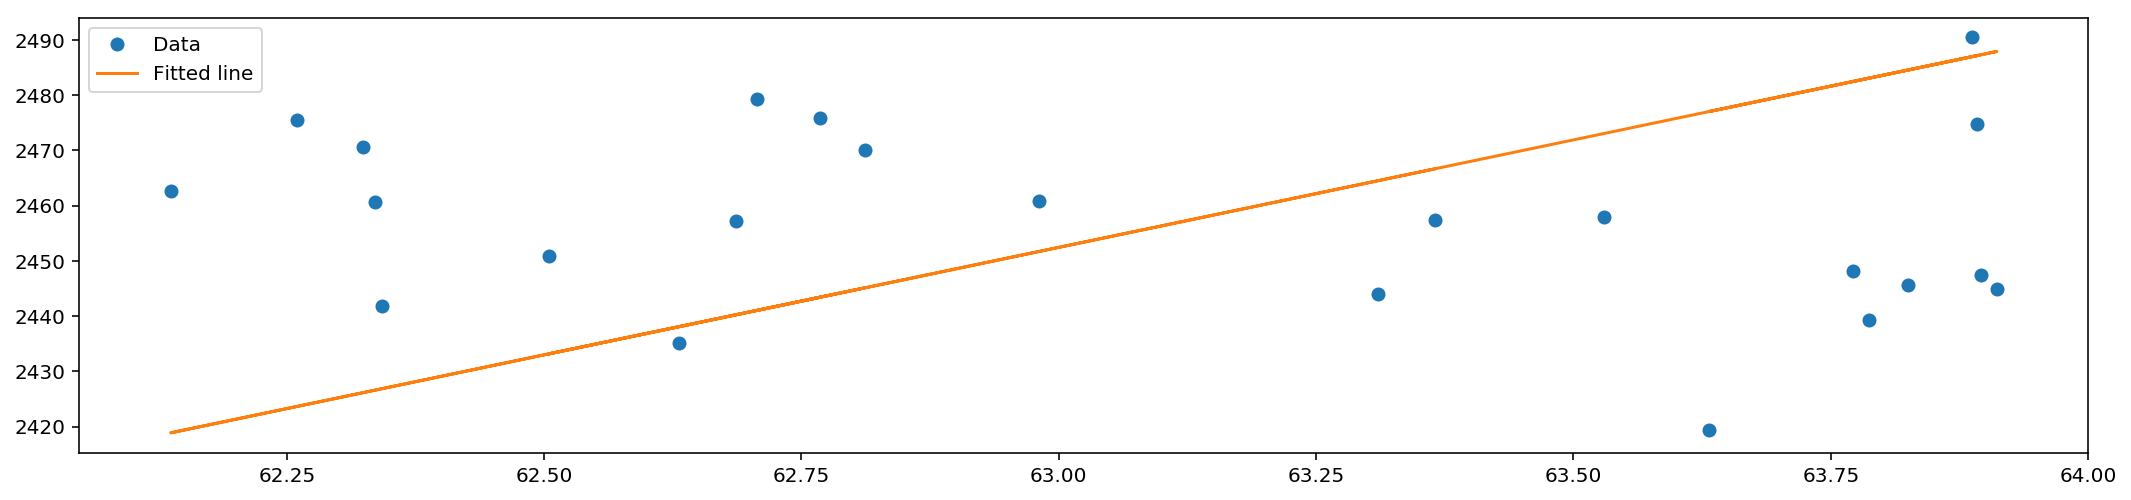

In [187]:
plt.figure(figsize=(18,4))
plt.plot(dual_currency_basket_210917, gold_210917, 'o', label = 'Data');
plt.plot(dual_currency_basket_210917, 
         dnn_lr.get_weights(lr.W) * dual_currency_basket_210917 + dnn_lr.get_weights(lr.b), 
         label='Fitted line')
plt.legend();

In [188]:
print("Test prediction for dual currency basket = [62.7081  63.4157  63.9709]: \n")
print(dnn_lr.predict([62.7081, 63.4157, 63.9709]))

Test prediction for dual currency basket = [62.7081  63.4157  63.9709]: 

[ 2441.10375977  2468.62915039  2490.2265625 ]


## 4. Neural Networks
### 4.1 Neural Networks; TensorFlow
#### MLP

#### CNN

#### RNN 

### 4.2 Neural Networks; Tflearn
#### MLP

In [67]:
def mlp_mc_model():
    tf.reset_default_graph()
    
    nn = tflearn.input_data([None, 784])
    
    nn = tflearn.fully_connected(nn, 784, activation='ReLU')    
    nn = tflearn.fully_connected(nn, 392, activation='ReLU')
    
    nn = tflearn.fully_connected(nn, 10, activation='Softmax')
    
    acc = tflearn.metrics.Accuracy()
    nn = tflearn.regression(nn, optimizer='adam', learning_rate=0.01, 
                            loss='categorical_crossentropy', metric=acc)
    model = tflearn.DNN(nn)
    return model

mlp_mc_model = mlp_mc_model()

In [68]:
mlp_mc_model.fit(X_train, y_train, validation_set=0.1, show_metric=True, batch_size=128, n_epoch=30)

Training Step: 11609  | total loss: 1.64038 | time: 12.453s
| Adam | epoch: 030 | loss: 1.64038 - acc: 0.9167 -- iter: 49408/49500
Training Step: 11610  | total loss: 1.47882 | time: 13.489s
| Adam | epoch: 030 | loss: 1.47882 - acc: 0.9242 | val_loss: 0.20089 - val_acc: 0.9687 -- iter: 49500/49500
--


In [69]:
y_test_mlp = np.array(mlp_model.predict(X_test)).argmax(axis=1)
y_test_num = y_test.argmax(axis=1)

test_accuracy_mlp = np.mean(y_test_mlp == y_test_num, axis=0)

print("Test Accuracy: {} %".format(test_accuracy_mlp*100))

Test Accuracy: 95.53 %


#### CNN

In [10]:
def cnn_mc_model():
    tf.reset_default_graph()
    
    nn = tflearn.input_data([None, 28, 28, 1], name='input')
    
    nn = tflearn.layers.conv.conv_2d(nn, 42, 3, activation='relu', regularizer="L2")    
    nn = tflearn.layers.conv.max_pool_2d(nn, 2)    
    nn = tflearn.layers.normalization.local_response_normalization(nn)
                                     
    nn = tflearn.layers.conv.conv_2d(nn, 84, 3, activation='relu', regularizer="L2")    
    nn = tflearn.layers.conv.max_pool_2d(nn, 2)                                      
    nn = tflearn.layers.normalization.local_response_normalization(nn)
    
    nn = tflearn.fully_connected(nn, 128, activation='relu')
    nn = tflearn.dropout(nn, 0.5)
    
    nn = tflearn.fully_connected(nn, 10, activation='Softmax')
    
    acc = tflearn.metrics.Accuracy()
    nn = tflearn.regression(nn, optimizer='adam', loss='categorical_crossentropy',
                            learning_rate=0.01, metric=acc, name='target')
    
    model = tflearn.DNN(nn)
    return model

cnn_mc_model = cnn_mc_model()

In [11]:
cnn_mc_model.fit({'input': X_train.reshape(-1, 28, 28, 1)}, {'target': y_train}, n_epoch=10,
                validation_set=({'input': X_test.reshape(-1, 28, 28, 1)}, {'target': y_test}),
                snapshot_step=100, show_metric=True, run_id='convnet_mnist')

Training Step: 8599  | total loss: 0.27999 | time: 384.871s
| Adam | epoch: 010 | loss: 0.27999 - acc: 0.9588 -- iter: 54976/55000
Training Step: 8600  | total loss: 0.25644 | time: 400.348s
| Adam | epoch: 010 | loss: 0.25644 - acc: 0.9614 | val_loss: 0.06244 - val_acc: 0.9826 -- iter: 55000/55000
--


#### RNN

## 5. Applications

## 6. Deep Learning
### Image Generation 
[Extended Version](https://olgabelitskaya.github.io/DL_ND_P5_V0.html)

In [142]:
# Parameters
stddev = 0.01
alpha = 0.1
learning_rate = 0.0002
beta1 = 0.5 
z_dim = 128
batch_size = 32
epochs = 2

In [143]:
def get_batches(images, batch_size):
    current_index = 0
    while current_index + batch_size <= images.shape[0]:
        data_batch = images[current_index:current_index + batch_size]
        current_index += batch_size
        yield data_batch / 255 - 0.5

In [144]:
def images_square_grid(images, mode):
    save_size = math.floor(np.sqrt(images.shape[0]))
    images = (((images - images.min()) * 255) / (images.max() - images.min())).astype(np.uint8)
    images_in_square = np.reshape(images[:save_size*save_size],
                                  (save_size, save_size, 
                                   images.shape[1], images.shape[2], images.shape[3]))
    if mode == 'L':
        images_in_square = np.squeeze(images_in_square, 4)

    new_im = Image.new(mode, (images.shape[1] * save_size, images.shape[2] * save_size))
    for col_i, col_images in enumerate(images_in_square):
        for image_i, image in enumerate(col_images):
            im = Image.fromarray(image, mode)
            new_im.paste(im, (col_i * images.shape[1], image_i * images.shape[2]))

    return new_im

In [145]:
def nn_inputs(image_width, image_height, image_channels, z_dim):
    input_real = tf.placeholder(tf.float32, 
                                shape=[None, image_width, image_height, image_channels], # rank 4
                                name="Real_Input") 
    
    input_z = tf.placeholder(tf.float32, shape=[None, z_dim], name="Z_Input") # rank 2    
    input_learning_rate = tf.placeholder(tf.float32, shape=[], name="Learning_Rate") # rank 0
    
    return input_real, input_z, input_learning_rate

In [146]:
def nn_discriminator(images, reuse=False, alpha=alpha):
    with tf.variable_scope('discriminator', reuse=reuse):
        # image shape [28,28,3]
        x = tf.layers.conv2d(images, 32, 5, strides=2,
                             kernel_initializer=tf.random_normal_initializer(stddev=stddev), 
                             padding='same')
        x = tf.maximum(x * alpha, x) 
        
        # input shape [14,14,32]       
        x = tf.layers.conv2d(x, 96, 5, strides=2,
                             kernel_initializer=tf.random_normal_initializer(stddev=stddev), 
                             padding='same')
        x = tf.maximum(x * alpha, x)        
        x = tf.layers.batch_normalization(x, training=True)

        # input shape [7,7,96]        
        x = tf.layers.conv2d(x, 128, 5, strides=2,
                             kernel_initializer=tf.random_normal_initializer(stddev=stddev), 
                             padding='same')
        x = tf.maximum(x * alpha, x)       
        x = tf.layers.batch_normalization(x, training=True)

        # input shape [4,4,128]       
        x = tf.reshape(x, (-1, 4*4*128))
        
        discriminator_logits = tf.layers.dense(x, 1)
        discriminator_outputs = tf.sigmoid(discriminator_logits)
        
    return discriminator_outputs, discriminator_logits

In [147]:
def nn_generator(z, out_channel_dim, is_train=True, alpha=alpha):

    with tf.variable_scope('generator', reuse=(not is_train)):
        
        x = tf.layers.dense(z, 7*7*128)
        x = tf.reshape(x, (-1, 7, 7, 128))
        x = tf.maximum(x * alpha, x)  
        
        x = tf.layers.batch_normalization(x, training=is_train)
        
        # input shape [7,7,128]       
        x = tf.layers.conv2d_transpose(x, 96, 5, strides=2, 
                                       kernel_initializer=tf.random_normal_initializer(stddev=stddev), 
                                       padding='same')
        x = tf.maximum(x * alpha, x)  
        
        x = tf.layers.batch_normalization(x, training=is_train)

        # input shape [14,14,96]
        x = tf.layers.conv2d_transpose(x, 32, 5, strides=2,
                                       kernel_initializer=tf.random_normal_initializer(stddev=stddev), 
                                       padding='same')
        x = tf.maximum(x * alpha, x)  
            
        x = tf.layers.batch_normalization(x, training=is_train)

        # input shape [28,28,32]        
        generator_logits = \
        tf.layers.conv2d_transpose(x, out_channel_dim, 3, strides=1, 
                                   kernel_initializer=tf.random_normal_initializer(stddev=stddev), 
                                   padding='same')

        # input shape [28,28,3]         
        generator_outputs = tf.tanh(generator_logits)
    
    return generator_outputs    

In [148]:
def nn_loss(input_real, input_z, out_channel_dim, alpha=alpha, index="leaky_relu"):    
    if index=="relu":
        img_generator = generator(input_z, out_channel_dim, is_train=True, alpha=alpha)
        real_outputs, real_logits = discriminator(input_real, reuse=False, alpha=alpha)
        generator_outputs, generator_logits = discriminator(img_generator, reuse=True, alpha=alpha)
    elif index=="leaky_relu":
        img_generator = nn_generator(input_z, out_channel_dim, is_train=True, alpha=alpha)
        real_outputs, real_logits = nn_discriminator(input_real, alpha=alpha)
        generator_outputs, generator_logits = nn_discriminator(img_generator, reuse=True, alpha=alpha)        
    
    real_labels = tf.ones_like(real_outputs) * (1 - alpha)
    zeros_labels = tf.zeros_like(generator_outputs)
    ones_labels = tf.ones_like(generator_outputs)

    real_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=real_logits, 
                                                                       labels=real_labels))
    zeros_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=generator_logits, 
                                                                        labels=zeros_labels))
    ones_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=generator_logits, 
                                                                       labels=ones_labels))

    return real_loss + zeros_loss, ones_loss

In [149]:
def nn_optimizer(discriminator_loss, generator_loss, learning_rate, beta1):

    trainable_variables = tf.trainable_variables()
    discriminator_trainable_variables = \
    [v for v in trainable_variables if v.name.startswith('discriminator')]
    generator_trainable_variables = \
    [v for v in trainable_variables if v.name.startswith('generator')]
    
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    discriminator_update_ops = \
    [u for u in update_ops if u.name.startswith('discriminator')]
    generator_update_ops = \
    [u for u in update_ops if u.name.startswith('generator')]

    with tf.control_dependencies(discriminator_update_ops):
        discriminator_training_operations = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).\
        minimize(discriminator_loss, var_list=discriminator_trainable_variables)

    with tf.control_dependencies(generator_update_ops):
        generator_training_operations = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).\
        minimize(generator_loss, var_list=generator_trainable_variables)
            
    return discriminator_training_operations, generator_training_operations

In [150]:
def train(images, epoch_count, batch_size, z_dim, learning_rate, beta1, 
          data_shape, data_image_mode, print_step, show_step):
    
    input_real, input_z, input_learning_rate = \
    nn_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    
    discriminator_loss, generator_loss = \
    nn_loss(input_real, input_z, data_shape[3], alpha=alpha, index="leaky_relu")
    
    discriminator_training_operations, generator_training_operations = \
    nn_optimizer(discriminator_loss, generator_loss, learning_rate, beta1)
    
    train_step = 0
    DTL, GTL = [], []
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(images, batch_size):
 
                train_step += 1
                batch_images *= 2.0
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                _ = sess.run(discriminator_training_operations, 
                             feed_dict={input_real: batch_images, input_z: batch_z})
                _ = sess.run(generator_training_operations, 
                             feed_dict={input_z: batch_z})

                if train_step % print_step == 0:
                    discriminator_training_loss = \
                    discriminator_loss.eval({input_real: batch_images, input_z: batch_z})
                    generator_training_loss= \
                    generator_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}| Step {}|".format(epoch_i + 1, epochs, train_step),
                          "Discriminator Loss:{:.5f}|".format(discriminator_training_loss),
                          "Generator Loss:{:.5f}|".format(generator_training_loss),
                          "Discriminator Loss>Generator Loss: {}"\
                          .format(discriminator_training_loss>generator_training_loss))
                    
                    DTL.append(discriminator_training_loss) 
                    GTL.append(generator_training_loss) 
                    
                if train_step % show_step == 0:
                    cmap = None if data_image_mode == 'RGB' else cm.bone
                    z_dim = input_z.get_shape().as_list()[-1]
                    example_z = np.random.uniform(-1, 1, size=[25, z_dim])

                    samples = sess.run(nn_generator(input_z, data_shape[3], 
                                                    is_train=False, alpha=alpha),
                                                    feed_dict={input_z: example_z})

                    images_grid = images_square_grid(samples, data_image_mode)
                    plt.figure(figsize=(6, 6))
                    plt.imshow(images_grid, cmap=cmap)
                    plt.show()
                            
    plt.figure(figsize=(18, 6))
    plt.plot(DTL, label = 'discriminator')
    plt.plot(GTL, label = 'generator')
    plt.legend()
    plt.title('Loss Function');

Epoch 1/2| Step 100| Discriminator Loss:0.32657| Generator Loss:6.75521| Discriminator Loss>Generator Loss: False
Epoch 1/2| Step 200| Discriminator Loss:0.33676| Generator Loss:5.11474| Discriminator Loss>Generator Loss: False
Epoch 1/2| Step 300| Discriminator Loss:1.15941| Generator Loss:0.58311| Discriminator Loss>Generator Loss: True
Epoch 1/2| Step 400| Discriminator Loss:0.76828| Generator Loss:1.18114| Discriminator Loss>Generator Loss: False
Epoch 1/2| Step 500| Discriminator Loss:1.00992| Generator Loss:1.05675| Discriminator Loss>Generator Loss: False
Epoch 1/2| Step 600| Discriminator Loss:1.27090| Generator Loss:0.57872| Discriminator Loss>Generator Loss: True
Epoch 1/2| Step 700| Discriminator Loss:1.23277| Generator Loss:0.82624| Discriminator Loss>Generator Loss: True
Epoch 1/2| Step 800| Discriminator Loss:1.34764| Generator Loss:0.58987| Discriminator Loss>Generator Loss: True
Epoch 1/2| Step 900| Discriminator Loss:1.31130| Generator Loss:0.92112| Discriminator Loss>

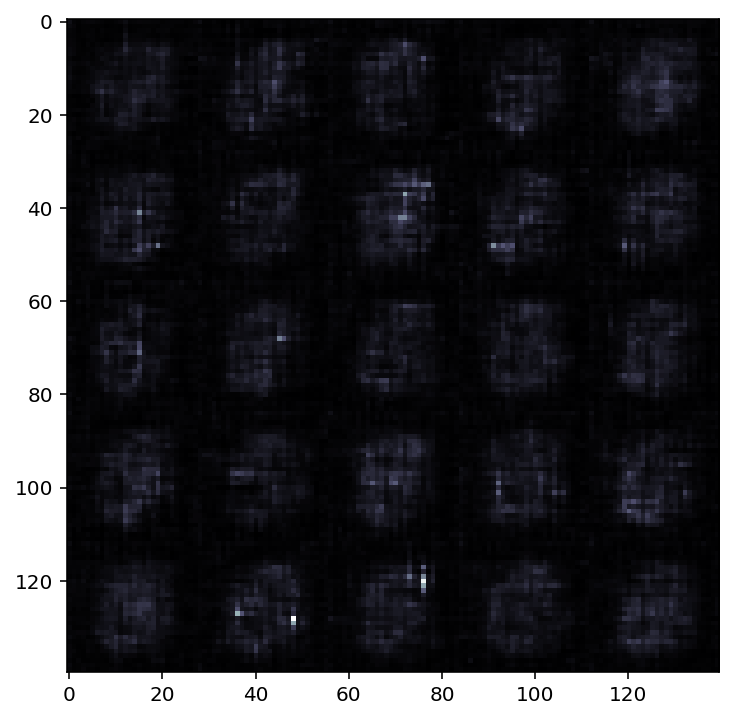

Epoch 1/2| Step 1100| Discriminator Loss:1.43163| Generator Loss:1.36249| Discriminator Loss>Generator Loss: True
Epoch 1/2| Step 1200| Discriminator Loss:1.42991| Generator Loss:1.31244| Discriminator Loss>Generator Loss: True
Epoch 1/2| Step 1300| Discriminator Loss:1.32669| Generator Loss:0.82799| Discriminator Loss>Generator Loss: True
Epoch 1/2| Step 1400| Discriminator Loss:1.39942| Generator Loss:0.57240| Discriminator Loss>Generator Loss: True
Epoch 1/2| Step 1500| Discriminator Loss:1.34089| Generator Loss:0.81431| Discriminator Loss>Generator Loss: True
Epoch 1/2| Step 1600| Discriminator Loss:1.46814| Generator Loss:1.26852| Discriminator Loss>Generator Loss: True
Epoch 1/2| Step 1700| Discriminator Loss:1.36049| Generator Loss:0.80711| Discriminator Loss>Generator Loss: True
Epoch 2/2| Step 1800| Discriminator Loss:1.53408| Generator Loss:0.50129| Discriminator Loss>Generator Loss: True
Epoch 2/2| Step 1900| Discriminator Loss:1.34132| Generator Loss:0.82457| Discriminator 

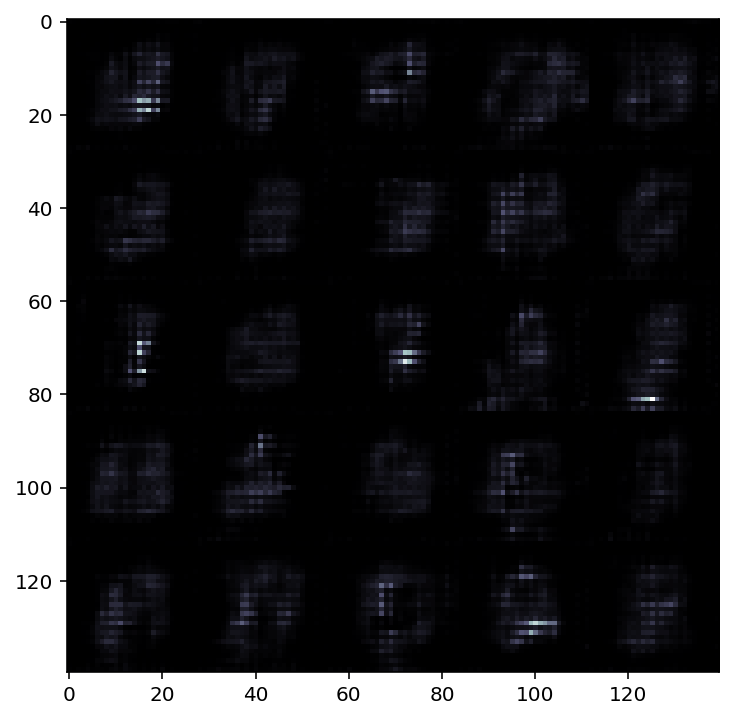

Epoch 2/2| Step 2100| Discriminator Loss:1.53826| Generator Loss:0.50302| Discriminator Loss>Generator Loss: True
Epoch 2/2| Step 2200| Discriminator Loss:1.46144| Generator Loss:0.75434| Discriminator Loss>Generator Loss: True
Epoch 2/2| Step 2300| Discriminator Loss:1.47468| Generator Loss:0.65138| Discriminator Loss>Generator Loss: True
Epoch 2/2| Step 2400| Discriminator Loss:1.28412| Generator Loss:0.96868| Discriminator Loss>Generator Loss: True
Epoch 2/2| Step 2500| Discriminator Loss:1.36248| Generator Loss:0.78037| Discriminator Loss>Generator Loss: True
Epoch 2/2| Step 2600| Discriminator Loss:1.37468| Generator Loss:0.75409| Discriminator Loss>Generator Loss: True
Epoch 2/2| Step 2700| Discriminator Loss:1.37595| Generator Loss:0.77816| Discriminator Loss>Generator Loss: True
Epoch 2/2| Step 2800| Discriminator Loss:1.36320| Generator Loss:0.79281| Discriminator Loss>Generator Loss: True
Epoch 2/2| Step 2900| Discriminator Loss:1.36282| Generator Loss:0.82002| Discriminator 

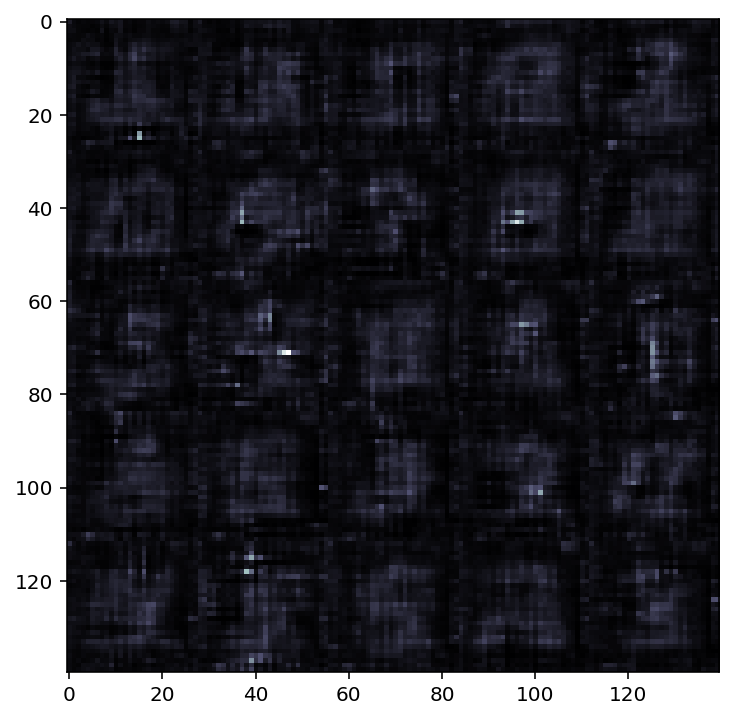

Epoch 2/2| Step 3100| Discriminator Loss:1.36613| Generator Loss:0.80173| Discriminator Loss>Generator Loss: True
Epoch 2/2| Step 3200| Discriminator Loss:1.36736| Generator Loss:0.80273| Discriminator Loss>Generator Loss: True
Epoch 2/2| Step 3300| Discriminator Loss:1.36809| Generator Loss:0.80040| Discriminator Loss>Generator Loss: True
Epoch 2/2| Step 3400| Discriminator Loss:1.36943| Generator Loss:0.80545| Discriminator Loss>Generator Loss: True


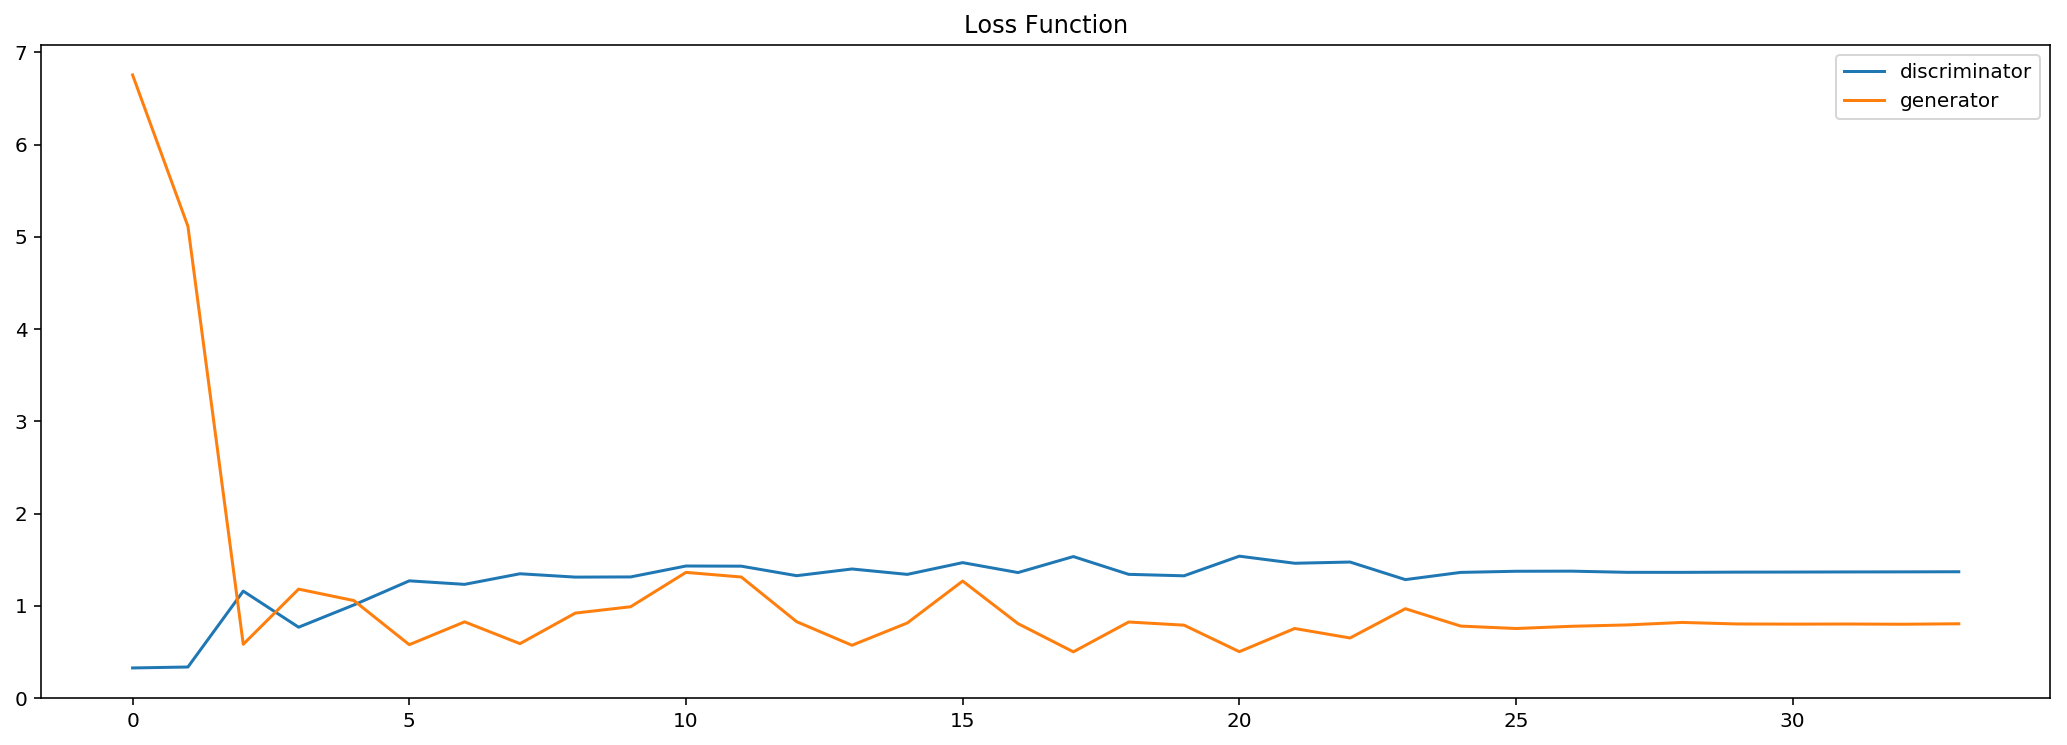

In [151]:
with tf.Graph().as_default():
    train(digit_images, epochs, batch_size, z_dim, learning_rate, beta1, 
          digit_images.shape, "L", 100, 1000)

### Text Generation